# TM10007 Assignment ECG - group 3

### Data loading, save features and labels into dataframe 

In [1]:
import zipfile
import os
import pandas as pd

with zipfile.ZipFile('./ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./ecg/')

data = pd.read_csv('./ecg/ecg_data.csv', index_col=0)

file = './ecg/ecg_data.csv'
if(os.path.exists(file) and os.path.isfile(file)):
  os.remove(file)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

y = data.label
X = data.drop('label', axis=1)

The number of samples: 827
The number of columns: 9001


### Learning Curve function 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA 
from sklearn.feature_selection import SelectKBest, chi2, SequentialFeatureSelector
from sklearn.naive_bayes import GaussianNB
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC

def plot_learning_curve(clf, X_train, y_train, plot):
    train_size, train_scores, test_scores = learning_curve(clf, X, y, verbose=2)
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plot.plot(train_size, train_mean, color='b', label='training')
    plot.plot(train_size, test_mean, color='orange', label='validation')

    plot.fill_between(train_size, train_mean-train_std, train_mean+train_std, color='b', alpha=0.3)
    plot.fill_between(train_size, test_mean-test_std, test_mean+test_std, color='orange', alpha=0.3)
    
    plot.grid()
    plot.set_ylim([0, 1.1])
    plot.set_xlabel('Training examples')
    plot.set_ylabel('Score')
    plot.legend()

# Random forest classifier 

### Loop of test-training  and evaluation loop

In [3]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA 
from sklearn.feature_selection import SelectKBest, chi2, SequentialFeatureSelector
from sklearn.naive_bayes import GaussianNB
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, Normalizer

# Aantal splits
N_SPLITS = 5

# Kijken of stratified shuffle een betere stabiliteit geeft
rs = ShuffleSplit(n_splits=N_SPLITS, test_size=.3) ## moeten voordat we hem inleveren nog random state toevoegen! 

scores = {'f1': [], 'accuracy': []}    ## Wat is een andere score die wat meer zegt dan accuracy? Of alleen F1? 
fitted_clf_list = []

fig, axs = plt.subplots(N_SPLITS, figsize=(10, 10))

for i, (train_index, test_index) in enumerate(rs.split(X, y)):

    # Data split
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_test = X.iloc[test_index]
    y_test = y[test_index]

    # PCA plot of training data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_scaled = scaler.transform(X_train)

# we dachten PCA scatterplots van verschillende data toevoegen in subplot 
    #pca = decomposition.PCA(n_components=3)
    #pca.fit(X_scaled)
    #X_pca = pca.transform(X_scaled)
    #ax = plt.subplot(3, 2, n + 1)
    #seaborn.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train, ax=ax)

    # Preprocessing
    scaler = StandardScaler()
    random_forest = RandomForestClassifier()
    pca = PCA()

    # Pipeline
    pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ("random_forest", random_forest)])

    # GridSearch

    # Random grid:
    n_estimators = [int(x) for x in np.linspace(start=50, stop=200)]
    max_features = ['auto', 'sqrt', 'log2', 0.1]
    max_depth = [int(x) for x in np.linspace(10, 120, num = 12)]
    min_samples_leaf = [1, 3, 5]
    bootstrap = [True, False]

    random_grid = {'random_forest__n_estimators': n_estimators,
    'random_forest__max_features': max_features,
    'random_forest__max_depth': max_depth,
    'random_forest__min_samples_leaf': min_samples_leaf,
    'random_forest__bootstrap': bootstrap}

    search = RandomizedSearchCV(pipe, random_grid, cv=3, scoring = 'f1', verbose=2, n_iter= 20)
    search.fit(X_train, y_train)
    best_clf = search.best_estimator_
    fitted_clf_list.append(search)

    y_pred = best_clf.predict(X_test)
    scores['f1'] += [f1_score(y_test, y_pred)]
    scores['accuracy'] += [accuracy_score(y_test, y_pred)]
    
    plot_learning_curve(best_clf, X_train, y_train, axs[i])
    fig.suptitle(f'Learning curve for {str(type(best_clf[-1])).split(".")[-1][:-2]}')
plt.show()

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END random_forest__bootstrap=True, random_forest__max_depth=90, random_forest__max_features=auto, random_forest__min_samples_leaf=1, random_forest__n_estimators=102; total time=   1.0s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=90, random_forest__max_features=auto, random_forest__min_samples_leaf=1, random_forest__n_estimators=102; total time=   1.1s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=90, random_forest__max_features=auto, random_forest__min_samples_leaf=1, random_forest__n_estimators=102; total time=   1.0s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=40, random_forest__max_features=auto, random_forest__min_samples_leaf=3, random_forest__n_estimators=184; total time=   1.2s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=40, random_forest__max_features=auto, random_forest__min_samples_leaf=3, random_forest__n_estimators=184; total ti

In [48]:
scores['f1']
# variabiliteit is heeel groot tussen de verschillende test-train splits; hoe komt dat? Hij lijkt niet stabiel. 

[0.07843137254901962,
 0.22222222222222218,
 0.17857142857142855,
 0.1694915254237288,
 0.2641509433962264]

In [49]:
from IPython.display import display
# Denk een goede om van de 5 loops met verschillende test-train split de cv_results overzichtelijk te laten zien; 
# dan krijgen we inzicht in welke hyperparameters betere en minder goed werken; hier begin gemaakt maar hadden geen tijd om het af te maken 
import pandas as pd
for i, clf in enumerate(fitted_clf_list): 
    print(f'Results for split {i+1}:')
    param_df = pd.DataFrame(clf.cv_results_)

    cols = [c for c in param_df.columns if c.lower()[:5] != 'split']

    param_df = param_df[cols].sort_values(by='rank_test_score')
    display(param_df)


Results for split 1:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__n_estimators,param_random_forest__min_samples_leaf,param_random_forest__max_features,param_random_forest__max_depth,param_random_forest__bootstrap,params,mean_test_score,std_test_score,rank_test_score
7,3.647136,0.627747,0.237576,0.055870,117,3,0.1,120,True,"{'random_forest__n_estimators': 117, 'random_f...",0.084188,0.062601,1
5,2.113413,0.566136,0.216106,0.048488,80,1,log2,10,False,"{'random_forest__n_estimators': 80, 'random_fo...",0.068018,0.062028,2
6,2.240833,0.667587,0.227726,0.053770,77,1,sqrt,10,True,"{'random_forest__n_estimators': 77, 'random_fo...",0.051282,0.072524,3
8,2.521051,0.153149,0.181391,0.003896,200,3,sqrt,70,True,"{'random_forest__n_estimators': 200, 'random_f...",0.036537,0.025843,4
1,1.482631,0.044687,0.152260,0.002703,80,3,sqrt,110,True,"{'random_forest__n_estimators': 80, 'random_fo...",0.035088,0.049622,5
9,2.501885,0.393247,0.249519,0.057975,151,3,auto,120,True,"{'random_forest__n_estimators': 151, 'random_f...",0.035088,0.049622,5
3,1.609843,0.028983,0.183345,0.034263,175,1,log2,10,True,"{'random_forest__n_estimators': 175, 'random_f...",0.034188,0.048349,7
2,2.189759,0.076691,0.155508,0.016994,147,5,auto,50,False,"{'random_forest__n_estimators': 147, 'random_f...",0.018018,0.025481,8
0,2.237357,0.174035,0.167560,0.008457,200,5,auto,40,True,"{'random_forest__n_estimators': 200, 'random_f...",0.000000,0.000000,9
4,3.175327,0.979268,0.456319,0.118580,74,5,auto,100,True,"{'random_forest__n_estimators': 74, 'random_fo...",0.000000,0.000000,9


Results for split 2:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__n_estimators,param_random_forest__min_samples_leaf,param_random_forest__max_features,param_random_forest__max_depth,param_random_forest__bootstrap,params,mean_test_score,std_test_score,rank_test_score
6,6.203418,0.511542,0.259772,0.030653,160,3,0.1,70,False,"{'random_forest__n_estimators': 160, 'random_f...",0.131256,0.055457,1
0,3.791317,0.205673,0.264547,0.027380,132,1,sqrt,60,False,"{'random_forest__n_estimators': 132, 'random_f...",0.099208,0.038812,2
2,3.807715,0.610622,0.261145,0.033571,138,5,0.1,80,True,"{'random_forest__n_estimators': 138, 'random_f...",0.086439,0.023000,3
5,2.140652,0.075063,0.211923,0.022933,65,3,sqrt,120,False,"{'random_forest__n_estimators': 65, 'random_fo...",0.069300,0.023548,4
3,2.465590,0.177133,0.253494,0.046618,56,5,sqrt,100,False,"{'random_forest__n_estimators': 56, 'random_fo...",0.054080,0.001194,5
8,10.136137,10.388527,0.376692,0.037225,117,3,sqrt,10,True,"{'random_forest__n_estimators': 117, 'random_f...",0.053580,0.000671,6
7,3.197954,0.597720,0.298710,0.064823,117,5,sqrt,100,True,"{'random_forest__n_estimators': 117, 'random_f...",0.017544,0.024811,7
9,3.592055,0.585771,0.343587,0.070119,132,5,sqrt,40,True,"{'random_forest__n_estimators': 132, 'random_f...",0.017544,0.024811,7
1,1.939730,0.106924,0.244185,0.009111,95,3,log2,110,True,"{'random_forest__n_estimators': 95, 'random_fo...",0.000000,0.000000,9
4,1.777159,0.062967,0.219793,0.008920,102,5,log2,10,False,"{'random_forest__n_estimators': 102, 'random_f...",0.000000,0.000000,9


Results for split 3:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__n_estimators,param_random_forest__min_samples_leaf,param_random_forest__max_features,param_random_forest__max_depth,param_random_forest__bootstrap,params,mean_test_score,std_test_score,rank_test_score
7,5.514264,0.097605,0.170211,0.007021,169,1,0.1,20,False,"{'random_forest__n_estimators': 169, 'random_f...",0.240212,0.087761,1
6,1.803021,0.114116,0.159903,0.021196,50,1,auto,70,False,"{'random_forest__n_estimators': 50, 'random_fo...",0.172511,0.096455,2
1,2.122929,0.160100,0.193485,0.027577,108,3,auto,100,False,"{'random_forest__n_estimators': 108, 'random_f...",0.150132,0.080039,3
0,1.692202,0.094811,0.134108,0.005076,86,1,sqrt,40,True,"{'random_forest__n_estimators': 86, 'random_fo...",0.113770,0.055866,4
5,1.640641,0.054120,0.166714,0.027784,144,1,log2,50,True,"{'random_forest__n_estimators': 144, 'random_f...",0.080534,0.077980,5
3,2.611263,0.033256,0.158227,0.015536,163,5,0.1,110,True,"{'random_forest__n_estimators': 163, 'random_f...",0.068662,0.020574,6
8,1.787232,0.051465,0.190159,0.024456,154,1,log2,90,True,"{'random_forest__n_estimators': 154, 'random_f...",0.067828,0.060220,7
2,1.578329,0.168139,0.154234,0.005553,89,5,log2,100,False,"{'random_forest__n_estimators': 89, 'random_fo...",0.000000,0.000000,8
4,1.361488,0.056422,0.159231,0.019554,77,5,log2,100,False,"{'random_forest__n_estimators': 77, 'random_fo...",0.000000,0.000000,8
9,1.757455,0.079581,0.196025,0.015996,123,5,log2,90,False,"{'random_forest__n_estimators': 123, 'random_f...",0.000000,0.000000,8


Results for split 4:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__n_estimators,param_random_forest__min_samples_leaf,param_random_forest__max_features,param_random_forest__max_depth,param_random_forest__bootstrap,params,mean_test_score,std_test_score,rank_test_score
5,3.522897,0.193417,0.186501,0.024714,102,3,0.1,20,False,"{'random_forest__n_estimators': 102, 'random_f...",0.152667,0.042192,1
9,6.622373,0.373051,0.213761,0.023633,172,1,0.1,110,False,"{'random_forest__n_estimators': 172, 'random_f...",0.151819,0.042041,2
4,3.824084,0.476373,0.269629,0.042640,71,1,sqrt,90,False,"{'random_forest__n_estimators': 71, 'random_fo...",0.104412,0.083784,3
0,3.415825,0.193994,0.203455,0.020554,196,3,sqrt,80,False,"{'random_forest__n_estimators': 196, 'random_f...",0.073179,0.026929,4
2,2.199219,0.141324,0.209285,0.040888,80,1,auto,60,True,"{'random_forest__n_estimators': 80, 'random_fo...",0.071150,0.065397,5
6,3.433097,0.625951,0.376513,0.085642,129,3,auto,50,True,"{'random_forest__n_estimators': 129, 'random_f...",0.056085,0.045367,6
1,2.730729,0.363169,0.219315,0.052849,126,3,sqrt,10,False,"{'random_forest__n_estimators': 126, 'random_f...",0.054131,0.045406,7
3,3.710890,0.844990,0.408363,0.017501,200,3,auto,10,True,"{'random_forest__n_estimators': 200, 'random_f...",0.037037,0.052378,8
8,2.513850,0.275513,0.287577,0.021907,83,5,sqrt,120,False,"{'random_forest__n_estimators': 83, 'random_fo...",0.019608,0.027730,9
7,5.201456,0.657448,0.425041,0.130774,175,3,auto,10,True,"{'random_forest__n_estimators': 175, 'random_f...",0.019048,0.026937,10


Results for split 5:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__n_estimators,param_random_forest__min_samples_leaf,param_random_forest__max_features,param_random_forest__max_depth,param_random_forest__bootstrap,params,mean_test_score,std_test_score,rank_test_score
9,2.800033,0.185925,0.190409,0.019104,56,3,0.1,120,False,"{'random_forest__n_estimators': 56, 'random_fo...",0.160428,0.046447,1
3,2.870218,0.141887,0.229004,0.026032,62,1,auto,100,False,"{'random_forest__n_estimators': 62, 'random_fo...",0.099695,0.042512,2
4,3.403699,0.180212,0.284256,0.070554,114,3,0.1,40,True,"{'random_forest__n_estimators': 114, 'random_f...",0.098413,0.040886,3
8,5.612525,0.958984,0.244379,0.063118,144,1,0.1,100,True,"{'random_forest__n_estimators': 144, 'random_f...",0.096204,0.004498,4
5,2.935487,0.155670,0.303695,0.063272,74,1,auto,10,False,"{'random_forest__n_estimators': 74, 'random_fo...",0.067608,0.047909,5
1,2.608886,0.034701,0.230282,0.050401,129,1,auto,40,True,"{'random_forest__n_estimators': 129, 'random_f...",0.065934,0.046718,6
7,2.913824,0.187886,0.295542,0.022231,157,1,log2,40,True,"{'random_forest__n_estimators': 157, 'random_f...",0.049290,0.038953,7
6,4.243246,0.268839,0.289562,0.011557,160,3,auto,110,False,"{'random_forest__n_estimators': 160, 'random_f...",0.034188,0.048349,8
0,3.052151,0.551894,0.308553,0.132531,200,3,log2,20,False,"{'random_forest__n_estimators': 200, 'random_f...",0.000000,0.000000,9
2,1.870116,0.292833,0.242831,0.052953,83,5,log2,90,True,"{'random_forest__n_estimators': 83, 'random_fo...",0.000000,0.000000,9


# Naive Bayes

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END nbayes__var_smoothing=8.111308307896872e-05, select__k=4330; total time=   0.6s
[CV] END nbayes__var_smoothing=8.111308307896872e-05, select__k=4330; total time=   0.6s
[CV] END nbayes__var_smoothing=8.111308307896872e-05, select__k=4330; total time=   0.7s
[CV] END nbayes__var_smoothing=0.533669923120631, select__k=7410; total time=   0.8s
[CV] END nbayes__var_smoothing=0.533669923120631, select__k=7410; total time=   0.8s
[CV] END nbayes__var_smoothing=0.533669923120631, select__k=7410; total time=   0.8s
[CV] END nbayes__var_smoothing=0.01519911082952933, select__k=4347; total time=   0.6s
[CV] END nbayes__var_smoothing=0.01519911082952933, select__k=4347; total time=   0.6s
[CV] END nbayes__var_smoothing=0.01519911082952933, select__k=4347; total time=   0.6s
[CV] END nbayes__var_smoothing=0.01519911082952933, select__k=3190; total time=   0.5s
[CV] END nbayes__var_smoothing=0.01519911082952933, select__k=3190; t

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.9s
[CV] END .................................................... total time=   1.2s
[CV] END .................................................... total time=   1.4s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.8s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   30.8s finished


[CV] END nbayes__var_smoothing=2.848035868435799e-07, select__k=6745; total time=   0.8s
[CV] END nbayes__var_smoothing=2.848035868435799e-07, select__k=6745; total time=   0.6s
[CV] END nbayes__var_smoothing=2.848035868435799e-07, select__k=6745; total time=   0.6s
[CV] END nbayes__var_smoothing=0.0002848035868435802, select__k=2157; total time=   0.5s
[CV] END nbayes__var_smoothing=0.0002848035868435802, select__k=2157; total time=   0.5s
[CV] END nbayes__var_smoothing=0.0002848035868435802, select__k=2157; total time=   0.5s
[CV] END nbayes__var_smoothing=2.848035868435799e-07, select__k=6957; total time=   0.8s
[CV] END nbayes__var_smoothing=2.848035868435799e-07, select__k=6957; total time=   0.7s
[CV] END nbayes__var_smoothing=2.848035868435799e-07, select__k=6957; total time=   0.8s
[CV] END nbayes__var_smoothing=5.336699231206302e-09, select__k=5895; total time=   0.6s
[CV] END nbayes__var_smoothing=5.336699231206302e-09, select__k=5895; total time=   0.6s
[CV] END nbayes__var_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.9s
[CV] END .................................................... total time=   1.1s
[CV] END .................................................... total time=   1.2s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   1.2s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.8s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   30.5s finished


[CV] END nbayes__var_smoothing=8.111308307896872e-07, select__k=2314; total time=   0.7s
[CV] END nbayes__var_smoothing=8.111308307896872e-07, select__k=2314; total time=   0.6s
[CV] END nbayes__var_smoothing=8.111308307896872e-07, select__k=2314; total time=   0.6s
[CV] END nbayes__var_smoothing=4.328761281083053e-06, select__k=225; total time=   0.5s
[CV] END nbayes__var_smoothing=4.328761281083053e-06, select__k=225; total time=   0.5s
[CV] END nbayes__var_smoothing=4.328761281083053e-06, select__k=225; total time=   0.5s
[CV] END nbayes__var_smoothing=0.003511191734215131, select__k=2505; total time=   0.6s
[CV] END nbayes__var_smoothing=0.003511191734215131, select__k=2505; total time=   0.5s
[CV] END nbayes__var_smoothing=0.003511191734215131, select__k=2505; total time=   0.6s
[CV] END nbayes__var_smoothing=0.1873817422860384, select__k=7992; total time=   0.7s
[CV] END nbayes__var_smoothing=0.1873817422860384, select__k=7992; total time=   0.7s
[CV] END nbayes__var_smoothing=0.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   1.0s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   19.5s finished


[CV] END nbayes__var_smoothing=1.519911082952933e-06, select__k=6945; total time=   0.9s
[CV] END nbayes__var_smoothing=1.519911082952933e-06, select__k=6945; total time=   0.8s
[CV] END nbayes__var_smoothing=1.519911082952933e-06, select__k=6945; total time=   0.8s
[CV] END nbayes__var_smoothing=2.310129700083158e-06, select__k=2366; total time=   0.6s
[CV] END nbayes__var_smoothing=2.310129700083158e-06, select__k=2366; total time=   0.6s
[CV] END nbayes__var_smoothing=2.310129700083158e-06, select__k=2366; total time=   0.7s
[CV] END nbayes__var_smoothing=2.848035868435799e-08, select__k=1889; total time=   0.9s
[CV] END nbayes__var_smoothing=2.848035868435799e-08, select__k=1889; total time=   0.5s
[CV] END nbayes__var_smoothing=2.848035868435799e-08, select__k=1889; total time=   0.6s
[CV] END nbayes__var_smoothing=1.519911082952933e-06, select__k=4317; total time=   0.7s
[CV] END nbayes__var_smoothing=1.519911082952933e-06, select__k=4317; total time=   0.7s
[CV] END nbayes__var_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   1.0s
[CV] END .................................................... total time=   1.2s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   1.0s
[CV] END .................................................... total time=   1.0s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   22.0s finished


[CV] END ........nbayes__var_smoothing=1e-09, select__k=4030; total time=   0.5s
[CV] END ........nbayes__var_smoothing=1e-09, select__k=4030; total time=   0.4s
[CV] END ........nbayes__var_smoothing=1e-09, select__k=4030; total time=   0.4s
[CV] END nbayes__var_smoothing=3.5111917342151275e-06, select__k=1629; total time=   0.4s
[CV] END nbayes__var_smoothing=3.5111917342151275e-06, select__k=1629; total time=   0.4s
[CV] END nbayes__var_smoothing=3.5111917342151275e-06, select__k=1629; total time=   0.4s
[CV] END nbayes__var_smoothing=0.12328467394420659, select__k=4960; total time=   0.4s
[CV] END nbayes__var_smoothing=0.12328467394420659, select__k=4960; total time=   0.6s
[CV] END nbayes__var_smoothing=0.12328467394420659, select__k=4960; total time=   0.5s
[CV] END nbayes__var_smoothing=6.579332246575683e-06, select__k=7025; total time=   0.6s
[CV] END nbayes__var_smoothing=6.579332246575683e-06, select__k=7025; total time=   0.6s
[CV] END nbayes__var_smoothing=6.579332246575683

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   27.8s finished


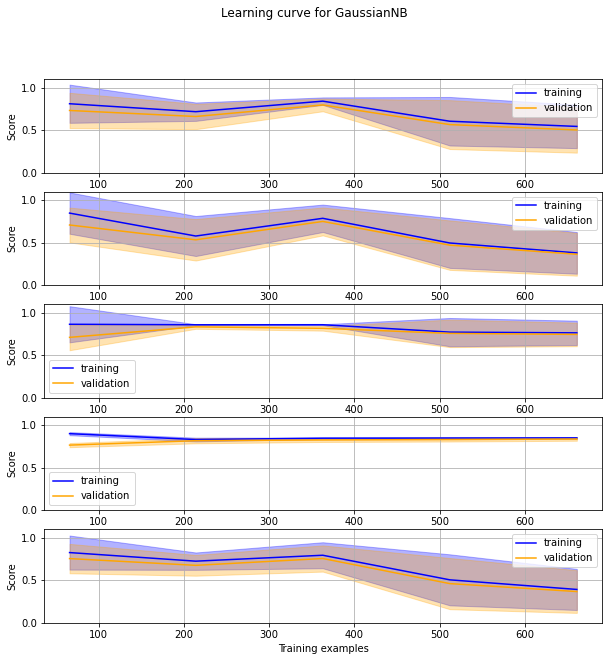

In [58]:
# Aantal splits
N_SPLITS = 5

# Kijken of stratified shuffle een betere stabiliteit geeft
rs = ShuffleSplit(n_splits=N_SPLITS, test_size=.3) ## moeten voordat we hem inleveren nog random state toevoegen! 

scores = {'f1': [], 'accuracy': []}    ## Wat is een andere score die wat meer zegt dan accuracy? Of alleen F1? 
fitted_clf_list = []

fig, axs = plt.subplots(N_SPLITS, figsize=(10, 10))

for i, (train_index, test_index) in enumerate(rs.split(X, y)):

    # Data split
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_test = X.iloc[test_index]
    y_test = y[test_index]

    # Preprocessing
    scaler = StandardScaler()
    naive_bayes = GaussianNB()
    pca = PCA()
    selector = SelectKBest()

    # Pipeline
    # Extra stap in de pipeline is nu de selector, PCA is uit de pipeline
    pipe = Pipeline(steps=[('select', selector), ("nbayes", naive_bayes)])

    # GridSearch

    # Random grid:
    var_smoothing = np.logspace(0,-9, num=100)
    k_select = np.arange(2, 150) # Kijken wat de bovengrens van select moet worden

    random_grid = {'nbayes__var_smoothing': var_smoothing,
    'select__k': k_select}

    # Hoeveel iteraties willen we?
    search = RandomizedSearchCV(pipe, random_grid, cv=3, scoring = 'f1', verbose=2, n_iter= 30)
    search.fit(X_train, y_train)
    best_clf = search.best_estimator_
    fitted_clf_list.append(search)

    y_pred = best_clf.predict(X_test)
    scores['f1'] += [f1_score(y_test, y_pred)]
    scores['accuracy'] += [accuracy_score(y_test, y_pred)]
    
    plot_learning_curve(best_clf, X_train, y_train, axs[i])
    fig.suptitle(f'Learning curve for {str(type(best_clf[-1])).split(".")[-1][:-2]}')
plt.show()

# TM10007 Assignment ECG - group 3

### Data loading, save features and labels into dataframe 

In [ ]:
import zipfile
import os
import pandas as pd

with zipfile.ZipFile('./ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./ecg/')

data = pd.read_csv('./ecg/ecg_data.csv', index_col=0)

file = './ecg/ecg_data.csv'
if(os.path.exists(file) and os.path.isfile(file)):
  os.remove(file)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

y = data.label
X = data.drop('label', axis=1)

The number of samples: 827
The number of columns: 9001


### Learning Curve function 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA 
from sklearn.feature_selection import SelectKBest, chi2, SequentialFeatureSelector
from sklearn.naive_bayes import GaussianNB
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC

def plot_learning_curve(clf, X_train, y_train, plot):
    train_size, train_scores, test_scores = learning_curve(clf, X, y, verbose=2)
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plot.plot(train_size, train_mean, color='b', label='training')
    plot.plot(train_size, test_mean, color='orange', label='validation')

    plot.fill_between(train_size, train_mean-train_std, train_mean+train_std, color='b', alpha=0.3)
    plot.fill_between(train_size, test_mean-test_std, test_mean+test_std, color='orange', alpha=0.3)
    
    plot.grid()
    plot.set_ylim([0, 1.1])
    plot.set_xlabel('Training examples')
    plot.set_ylabel('Score')
    plot.legend()

# Random forest classifier 

### Loop of test-training  and evaluation loop

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END random_forest__bootstrap=True, random_forest__max_depth=80, random_forest__max_features=log2, random_forest__min_samples_leaf=5, random_forest__n_estimators=80; total time=   0.9s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=80, random_forest__max_features=log2, random_forest__min_samples_leaf=5, random_forest__n_estimators=80; total time=   0.9s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=80, random_forest__max_features=log2, random_forest__min_samples_leaf=5, random_forest__n_estimators=80; total time=   1.0s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=120, random_forest__max_features=log2, random_forest__min_samples_leaf=3, random_forest__n_estimators=111; total time=   1.0s
[CV] END random_forest__bootstrap=True, random_forest__max_depth=120, random_forest__max_features=log2, random_forest__min_samples_leaf=3, random_forest__n_estimators=111; total tim

KeyboardInterrupt: 

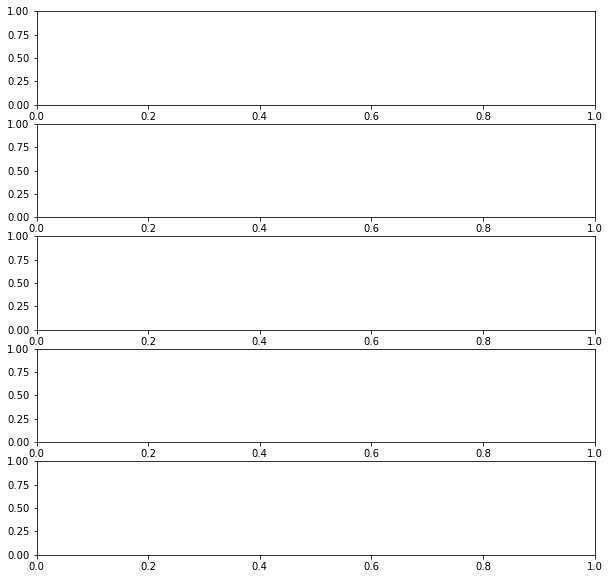

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA 
from sklearn.feature_selection import SelectKBest, chi2, SequentialFeatureSelector
from sklearn.naive_bayes import GaussianNB
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, Normalizer

# Aantal splits
N_SPLITS = 5

# Kijken of stratified shuffle een betere stabiliteit geeft
rs = ShuffleSplit(n_splits=N_SPLITS, test_size=.3) ## moeten voordat we hem inleveren nog random state toevoegen! 

scores = {'f1': [], 'accuracy': []}    ## Wat is een andere score die wat meer zegt dan accuracy? Of alleen F1? 
fitted_clf_list = []
n = -1

fig, axs = plt.subplots(N_SPLITS, figsize=(10, 10))

for i, (train_index, test_index) in enumerate(rs.split(X, y)):

    # Data split
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_test = X.iloc[test_index]
    y_test = y[test_index]
    n+= 1 

    # PCA plot of training data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_scaled = scaler.transform(X_train)

# we dachten PCA scatterplots van verschillende data toevoegen in subplot 
    #pca = decomposition.PCA(n_components=3)
    #pca.fit(X_scaled)
    #X_pca = pca.transform(X_scaled)
    #ax = plt.subplot(3, 2, n + 1)
    #seaborn.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train, ax=ax)

    # Preprocessing
    scaler = StandardScaler()
    random_forest = RandomForestClassifier()
    pca = PCA()

    # Pipeline
    pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ("random_forest", random_forest)])

    # GridSearch

    # Random grid:
    n_estimators = [int(x) for x in np.linspace(start=50, stop=200)]
    max_features = ['auto', 'sqrt', 'log2', 0.1]
    max_depth = [int(x) for x in np.linspace(10, 120, num = 12)]
    min_samples_leaf = [1, 3, 5]
    bootstrap = [True, False]

    random_grid = {'random_forest__n_estimators': n_estimators,
    'random_forest__max_features': max_features,
    'random_forest__max_depth': max_depth,
    'random_forest__min_samples_leaf': min_samples_leaf,
    'random_forest__bootstrap': bootstrap}


    #parameters = {'random_forest__n_estimators': [50, 100, 200], 'random_forest__max_features': ['sqrt', 'log2'], 'random_forest__min_samples_leaf': [1,3,5]} 
    search = RandomizedSearchCV(pipe, random_grid, cv=3, scoring = 'f1', verbose=2, n_iter= 10)
    search.fit(X_train, y_train)
    best_clf = search.best_estimator_
    fitted_clf_list.append(search)

    y_pred = best_clf.predict(X_test)
    scores['f1'] += [f1_score(y_test, y_pred)]
    scores['accuracy'] += [accuracy_score(y_test, y_pred)]
    
    plot_learning_curve(best_clf, X_train, y_train, axs[i])
    fig.suptitle(f'Learning curve for {str(type(best_clf[-1])).split(".")[-1][:-2]}')
plt.show()

In [ ]:
scores['f1']
# variabiliteit is heeel groot tussen de verschillende test-train splits; hoe komt dat? Hij lijkt niet stabiel. 

[0.07843137254901962,
 0.22222222222222218,
 0.17857142857142855,
 0.1694915254237288,
 0.2641509433962264]

In [ ]:
from IPython.display import display
# Denk een goede om van de 5 loops met verschillende test-train split de cv_results overzichtelijk te laten zien; 
# dan krijgen we inzicht in welke hyperparameters betere en minder goed werken; hier begin gemaakt maar hadden geen tijd om het af te maken 
import pandas as pd
for i, clf in enumerate(fitted_clf_list): 
    print(f'Results for split {i+1}:')
    param_df = pd.DataFrame(clf.cv_results_)

    cols = [c for c in param_df.columns if c.lower()[:5] != 'split']

    param_df = param_df[cols].sort_values(by='rank_test_score')
    display(param_df)


Results for split 1:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__n_estimators,param_random_forest__min_samples_leaf,param_random_forest__max_features,param_random_forest__max_depth,param_random_forest__bootstrap,params,mean_test_score,std_test_score,rank_test_score
7,3.647136,0.627747,0.237576,0.055870,117,3,0.1,120,True,"{'random_forest__n_estimators': 117, 'random_f...",0.084188,0.062601,1
5,2.113413,0.566136,0.216106,0.048488,80,1,log2,10,False,"{'random_forest__n_estimators': 80, 'random_fo...",0.068018,0.062028,2
6,2.240833,0.667587,0.227726,0.053770,77,1,sqrt,10,True,"{'random_forest__n_estimators': 77, 'random_fo...",0.051282,0.072524,3
8,2.521051,0.153149,0.181391,0.003896,200,3,sqrt,70,True,"{'random_forest__n_estimators': 200, 'random_f...",0.036537,0.025843,4
1,1.482631,0.044687,0.152260,0.002703,80,3,sqrt,110,True,"{'random_forest__n_estimators': 80, 'random_fo...",0.035088,0.049622,5
9,2.501885,0.393247,0.249519,0.057975,151,3,auto,120,True,"{'random_forest__n_estimators': 151, 'random_f...",0.035088,0.049622,5
3,1.609843,0.028983,0.183345,0.034263,175,1,log2,10,True,"{'random_forest__n_estimators': 175, 'random_f...",0.034188,0.048349,7
2,2.189759,0.076691,0.155508,0.016994,147,5,auto,50,False,"{'random_forest__n_estimators': 147, 'random_f...",0.018018,0.025481,8
0,2.237357,0.174035,0.167560,0.008457,200,5,auto,40,True,"{'random_forest__n_estimators': 200, 'random_f...",0.000000,0.000000,9
4,3.175327,0.979268,0.456319,0.118580,74,5,auto,100,True,"{'random_forest__n_estimators': 74, 'random_fo...",0.000000,0.000000,9


Results for split 2:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__n_estimators,param_random_forest__min_samples_leaf,param_random_forest__max_features,param_random_forest__max_depth,param_random_forest__bootstrap,params,mean_test_score,std_test_score,rank_test_score
6,6.203418,0.511542,0.259772,0.030653,160,3,0.1,70,False,"{'random_forest__n_estimators': 160, 'random_f...",0.131256,0.055457,1
0,3.791317,0.205673,0.264547,0.027380,132,1,sqrt,60,False,"{'random_forest__n_estimators': 132, 'random_f...",0.099208,0.038812,2
2,3.807715,0.610622,0.261145,0.033571,138,5,0.1,80,True,"{'random_forest__n_estimators': 138, 'random_f...",0.086439,0.023000,3
5,2.140652,0.075063,0.211923,0.022933,65,3,sqrt,120,False,"{'random_forest__n_estimators': 65, 'random_fo...",0.069300,0.023548,4
3,2.465590,0.177133,0.253494,0.046618,56,5,sqrt,100,False,"{'random_forest__n_estimators': 56, 'random_fo...",0.054080,0.001194,5
8,10.136137,10.388527,0.376692,0.037225,117,3,sqrt,10,True,"{'random_forest__n_estimators': 117, 'random_f...",0.053580,0.000671,6
7,3.197954,0.597720,0.298710,0.064823,117,5,sqrt,100,True,"{'random_forest__n_estimators': 117, 'random_f...",0.017544,0.024811,7
9,3.592055,0.585771,0.343587,0.070119,132,5,sqrt,40,True,"{'random_forest__n_estimators': 132, 'random_f...",0.017544,0.024811,7
1,1.939730,0.106924,0.244185,0.009111,95,3,log2,110,True,"{'random_forest__n_estimators': 95, 'random_fo...",0.000000,0.000000,9
4,1.777159,0.062967,0.219793,0.008920,102,5,log2,10,False,"{'random_forest__n_estimators': 102, 'random_f...",0.000000,0.000000,9


Results for split 3:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__n_estimators,param_random_forest__min_samples_leaf,param_random_forest__max_features,param_random_forest__max_depth,param_random_forest__bootstrap,params,mean_test_score,std_test_score,rank_test_score
7,5.514264,0.097605,0.170211,0.007021,169,1,0.1,20,False,"{'random_forest__n_estimators': 169, 'random_f...",0.240212,0.087761,1
6,1.803021,0.114116,0.159903,0.021196,50,1,auto,70,False,"{'random_forest__n_estimators': 50, 'random_fo...",0.172511,0.096455,2
1,2.122929,0.160100,0.193485,0.027577,108,3,auto,100,False,"{'random_forest__n_estimators': 108, 'random_f...",0.150132,0.080039,3
0,1.692202,0.094811,0.134108,0.005076,86,1,sqrt,40,True,"{'random_forest__n_estimators': 86, 'random_fo...",0.113770,0.055866,4
5,1.640641,0.054120,0.166714,0.027784,144,1,log2,50,True,"{'random_forest__n_estimators': 144, 'random_f...",0.080534,0.077980,5
3,2.611263,0.033256,0.158227,0.015536,163,5,0.1,110,True,"{'random_forest__n_estimators': 163, 'random_f...",0.068662,0.020574,6
8,1.787232,0.051465,0.190159,0.024456,154,1,log2,90,True,"{'random_forest__n_estimators': 154, 'random_f...",0.067828,0.060220,7
2,1.578329,0.168139,0.154234,0.005553,89,5,log2,100,False,"{'random_forest__n_estimators': 89, 'random_fo...",0.000000,0.000000,8
4,1.361488,0.056422,0.159231,0.019554,77,5,log2,100,False,"{'random_forest__n_estimators': 77, 'random_fo...",0.000000,0.000000,8
9,1.757455,0.079581,0.196025,0.015996,123,5,log2,90,False,"{'random_forest__n_estimators': 123, 'random_f...",0.000000,0.000000,8


Results for split 4:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__n_estimators,param_random_forest__min_samples_leaf,param_random_forest__max_features,param_random_forest__max_depth,param_random_forest__bootstrap,params,mean_test_score,std_test_score,rank_test_score
5,3.522897,0.193417,0.186501,0.024714,102,3,0.1,20,False,"{'random_forest__n_estimators': 102, 'random_f...",0.152667,0.042192,1
9,6.622373,0.373051,0.213761,0.023633,172,1,0.1,110,False,"{'random_forest__n_estimators': 172, 'random_f...",0.151819,0.042041,2
4,3.824084,0.476373,0.269629,0.042640,71,1,sqrt,90,False,"{'random_forest__n_estimators': 71, 'random_fo...",0.104412,0.083784,3
0,3.415825,0.193994,0.203455,0.020554,196,3,sqrt,80,False,"{'random_forest__n_estimators': 196, 'random_f...",0.073179,0.026929,4
2,2.199219,0.141324,0.209285,0.040888,80,1,auto,60,True,"{'random_forest__n_estimators': 80, 'random_fo...",0.071150,0.065397,5
6,3.433097,0.625951,0.376513,0.085642,129,3,auto,50,True,"{'random_forest__n_estimators': 129, 'random_f...",0.056085,0.045367,6
1,2.730729,0.363169,0.219315,0.052849,126,3,sqrt,10,False,"{'random_forest__n_estimators': 126, 'random_f...",0.054131,0.045406,7
3,3.710890,0.844990,0.408363,0.017501,200,3,auto,10,True,"{'random_forest__n_estimators': 200, 'random_f...",0.037037,0.052378,8
8,2.513850,0.275513,0.287577,0.021907,83,5,sqrt,120,False,"{'random_forest__n_estimators': 83, 'random_fo...",0.019608,0.027730,9
7,5.201456,0.657448,0.425041,0.130774,175,3,auto,10,True,"{'random_forest__n_estimators': 175, 'random_f...",0.019048,0.026937,10


Results for split 5:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__n_estimators,param_random_forest__min_samples_leaf,param_random_forest__max_features,param_random_forest__max_depth,param_random_forest__bootstrap,params,mean_test_score,std_test_score,rank_test_score
9,2.800033,0.185925,0.190409,0.019104,56,3,0.1,120,False,"{'random_forest__n_estimators': 56, 'random_fo...",0.160428,0.046447,1
3,2.870218,0.141887,0.229004,0.026032,62,1,auto,100,False,"{'random_forest__n_estimators': 62, 'random_fo...",0.099695,0.042512,2
4,3.403699,0.180212,0.284256,0.070554,114,3,0.1,40,True,"{'random_forest__n_estimators': 114, 'random_f...",0.098413,0.040886,3
8,5.612525,0.958984,0.244379,0.063118,144,1,0.1,100,True,"{'random_forest__n_estimators': 144, 'random_f...",0.096204,0.004498,4
5,2.935487,0.155670,0.303695,0.063272,74,1,auto,10,False,"{'random_forest__n_estimators': 74, 'random_fo...",0.067608,0.047909,5
1,2.608886,0.034701,0.230282,0.050401,129,1,auto,40,True,"{'random_forest__n_estimators': 129, 'random_f...",0.065934,0.046718,6
7,2.913824,0.187886,0.295542,0.022231,157,1,log2,40,True,"{'random_forest__n_estimators': 157, 'random_f...",0.049290,0.038953,7
6,4.243246,0.268839,0.289562,0.011557,160,3,auto,110,False,"{'random_forest__n_estimators': 160, 'random_f...",0.034188,0.048349,8
0,3.052151,0.551894,0.308553,0.132531,200,3,log2,20,False,"{'random_forest__n_estimators': 200, 'random_f...",0.000000,0.000000,9
2,1.870116,0.292833,0.242831,0.052953,83,5,log2,90,True,"{'random_forest__n_estimators': 83, 'random_fo...",0.000000,0.000000,9


# Naive Bayes

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END .........nbayes__var_smoothing=1e-09, select__k=139; total time=   0.3s
[CV] END .........nbayes__var_smoothing=1e-09, select__k=139; total time=   0.2s
[CV] END .........nbayes__var_smoothing=1e-09, select__k=139; total time=   0.3s
[CV] END nbayes__var_smoothing=3.5111917342151273e-09, select__k=92; total time=   0.2s
[CV] END nbayes__var_smoothing=3.5111917342151273e-09, select__k=92; total time=   0.2s
[CV] END nbayes__var_smoothing=3.5111917342151273e-09, select__k=92; total time=   0.2s
[CV] END nbayes__var_smoothing=6.579332246575683e-05, select__k=63; total time=   0.2s
[CV] END nbayes__var_smoothing=6.579332246575683e-05, select__k=63; total time=   0.2s
[CV] END nbayes__var_smoothing=6.579332246575683e-05, select__k=63; total time=   0.2s
[CV] END nbayes__var_smoothing=2.310129700083158e-08, select__k=2; total time=   0.2s
[CV] END nbayes__var_smoothing=2.310129700083158e-08, select__k=2; total time=   0.2s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   18.9s finished


[CV] END nbayes__var_smoothing=0.0012328467394420659, select__k=65; total time=   0.5s
[CV] END nbayes__var_smoothing=0.0012328467394420659, select__k=65; total time=   0.7s
[CV] END nbayes__var_smoothing=0.0012328467394420659, select__k=65; total time=   0.4s
[CV] END nbayes__var_smoothing=3.5111917342151273e-09, select__k=68; total time=   0.5s
[CV] END nbayes__var_smoothing=3.5111917342151273e-09, select__k=68; total time=   0.5s
[CV] END nbayes__var_smoothing=3.5111917342151273e-09, select__k=68; total time=   0.6s
[CV] END nbayes__var_smoothing=8.111308307896873e-08, select__k=114; total time=   0.5s
[CV] END nbayes__var_smoothing=8.111308307896873e-08, select__k=114; total time=   0.6s
[CV] END nbayes__var_smoothing=8.111308307896873e-08, select__k=114; total time=   0.4s
[CV] END nbayes__var_smoothing=0.1873817422860384, select__k=14; total time=   0.3s
[CV] END nbayes__var_smoothing=0.1873817422860384, select__k=14; total time=   0.2s
[CV] END nbayes__var_smoothing=0.1873817422

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   10.2s finished


[CV] END nbayes__var_smoothing=1.2328467394420635e-09, select__k=98; total time=   0.2s
[CV] END nbayes__var_smoothing=1.2328467394420635e-09, select__k=98; total time=   0.2s
[CV] END nbayes__var_smoothing=1.2328467394420635e-09, select__k=98; total time=   0.4s
[CV] END nbayes__var_smoothing=0.2848035868435802, select__k=32; total time=   0.2s
[CV] END nbayes__var_smoothing=0.2848035868435802, select__k=32; total time=   0.4s
[CV] END nbayes__var_smoothing=0.2848035868435802, select__k=32; total time=   0.2s
[CV] END nbayes__var_smoothing=1.232846739442066e-08, select__k=143; total time=   0.3s
[CV] END nbayes__var_smoothing=1.232846739442066e-08, select__k=143; total time=   0.2s
[CV] END nbayes__var_smoothing=1.232846739442066e-08, select__k=143; total time=   0.3s
[CV] END nbayes__var_smoothing=4.328761281083053e-06, select__k=54; total time=   0.2s
[CV] END nbayes__var_smoothing=4.328761281083053e-06, select__k=54; total time=   0.2s
[CV] END nbayes__var_smoothing=4.3287612810830

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   11.3s finished


[CV] END nbayes__var_smoothing=0.23101297000831597, select__k=29; total time=   0.3s
[CV] END nbayes__var_smoothing=0.23101297000831597, select__k=29; total time=   0.3s
[CV] END nbayes__var_smoothing=0.23101297000831597, select__k=29; total time=   0.3s
[CV] END nbayes__var_smoothing=0.3511191734215131, select__k=124; total time=   0.2s
[CV] END nbayes__var_smoothing=0.3511191734215131, select__k=124; total time=   0.3s
[CV] END nbayes__var_smoothing=0.3511191734215131, select__k=124; total time=   0.3s
[CV] END nbayes__var_smoothing=2.310129700083158e-07, select__k=142; total time=   0.3s
[CV] END nbayes__var_smoothing=2.310129700083158e-07, select__k=142; total time=   0.2s
[CV] END nbayes__var_smoothing=2.310129700083158e-07, select__k=142; total time=   0.3s
[CV] END nbayes__var_smoothing=0.002848035868435802, select__k=57; total time=   0.2s
[CV] END nbayes__var_smoothing=0.002848035868435802, select__k=57; total time=   0.4s
[CV] END nbayes__var_smoothing=0.002848035868435802, s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.5s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   17.3s finished


[CV] END nbayes__var_smoothing=4.328761281083062e-05, select__k=127; total time=   0.7s
[CV] END nbayes__var_smoothing=4.328761281083062e-05, select__k=127; total time=   0.6s
[CV] END nbayes__var_smoothing=4.328761281083062e-05, select__k=127; total time=   0.5s
[CV] END nbayes__var_smoothing=4.328761281083061e-09, select__k=32; total time=   0.5s
[CV] END nbayes__var_smoothing=4.328761281083061e-09, select__k=32; total time=   0.5s
[CV] END nbayes__var_smoothing=4.328761281083061e-09, select__k=32; total time=   0.5s
[CV] END nbayes__var_smoothing=1.2328467394420635e-09, select__k=116; total time=   0.5s
[CV] END nbayes__var_smoothing=1.2328467394420635e-09, select__k=116; total time=   0.5s
[CV] END nbayes__var_smoothing=1.2328467394420635e-09, select__k=116; total time=   0.6s
[CV] END nbayes__var_smoothing=0.23101297000831597, select__k=33; total time=   0.5s
[CV] END nbayes__var_smoothing=0.23101297000831597, select__k=33; total time=   0.6s
[CV] END nbayes__var_smoothing=0.23101

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   19.1s finished


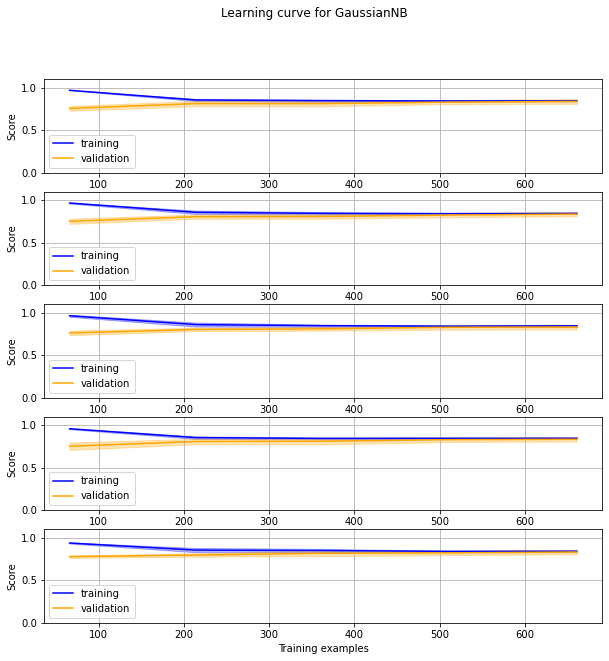

In [ ]:
# Aantal splits
N_SPLITS = 5

# Kijken of stratified shuffle een betere stabiliteit geeft
rs = ShuffleSplit(n_splits=N_SPLITS, test_size=.3) ## moeten voordat we hem inleveren nog random state toevoegen! 

scores = {'f1': [], 'accuracy': []}    ## Wat is een andere score die wat meer zegt dan accuracy? Of alleen F1? 
fitted_clf_list = []

fig, axs = plt.subplots(N_SPLITS, figsize=(10, 10))

for i, (train_index, test_index) in enumerate(rs.split(X, y)):

    # Data split
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_test = X.iloc[test_index]
    y_test = y[test_index]

    # Preprocessing
    scaler = StandardScaler()
    naive_bayes = GaussianNB()
    pca = PCA()
    selector = SelectKBest()

    # Pipeline
    # Extra stap in de pipeline is nu de selector, PCA is uit de pipeline
    pipe = Pipeline(steps=[('select', selector), ("nbayes", naive_bayes)])

    # GridSearch

    # Random grid:
    var_smoothing = np.logspace(0,-9, num=100)
    k_select = np.arange(2, 150) # Kijken wat de bovengrens van select moet worden

    random_grid = {'nbayes__var_smoothing': var_smoothing,
    'select__k': k_select}

    # Hoeveel iteraties willen we?
    search = RandomizedSearchCV(pipe, random_grid, cv=3, scoring = 'f1', verbose=2, n_iter= 30)
    search.fit(X_train, y_train)
    best_clf = search.best_estimator_
    fitted_clf_list.append(search)

    y_pred = best_clf.predict(X_test)
    scores['f1'] += [f1_score(y_test, y_pred)]
    scores['accuracy'] += [accuracy_score(y_test, y_pred)]
    
    plot_learning_curve(best_clf, X_train, y_train, axs[i])
    fig.suptitle(f'Learning curve for {str(type(best_clf[-1])).split(".")[-1][:-2]}')
plt.show()

In [ ]:
scores['f1']

[0.4782608695652174,
 0.37288135593220345,
 0.6041666666666666,
 0.40625,
 0.4761904761904762]

In [ ]:
scores['accuracy']

[0.8072289156626506,
 0.8514056224899599,
 0.8473895582329317,
 0.8473895582329317,
 0.8674698795180723]

In [ ]:
# variabiliteit is heeel groot tussen de verschillende test-train splits; hoe komt dat? Hij lijkt niet stabiel. 
from IPython.display import display
# Denk een goede om van de 5 loops met verschillende test-train split de cv_results overzichtelijk te laten zien; 
# dan krijgen we inzicht in welke hyperparameters betere en minder goed werken; hier begin gemaakt maar hadden geen tijd om het af te maken 
import pandas as pd
for i, clf in enumerate(fitted_clf_list): 
    print(f'Results for split {i+1}:')
    param_df = pd.DataFrame(clf.cv_results_)

    cols = [c for c in param_df.columns if c.lower()[:5] != 'split']

    param_df = param_df[cols].sort_values(by='rank_test_score')
    display(param_df)

Results for split 1:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_select__k,param_nbayes__var_smoothing,params,mean_test_score,std_test_score,rank_test_score
8,0.440200,0.074018,0.172042,0.056773,27,0.000004,"{'select__k': 27, 'nbayes__var_smoothing': 4.3...",0.475017,0.019358,1
7,0.308121,0.075454,0.098397,0.019221,60,0.001233,"{'select__k': 60, 'nbayes__var_smoothing': 0.0...",0.457034,0.026082,2
10,0.597852,0.098125,0.183417,0.068387,23,0.001874,"{'select__k': 23, 'nbayes__var_smoothing': 0.0...",0.452114,0.047036,3
21,0.428187,0.031085,0.135347,0.003570,58,0.0,"{'select__k': 58, 'nbayes__var_smoothing': 1.2...",0.445513,0.023972,4
2,0.225114,0.007343,0.054533,0.004899,63,0.000066,"{'select__k': 63, 'nbayes__var_smoothing': 6.5...",0.442431,0.030052,5
6,0.304576,0.008909,0.083152,0.017778,21,0.001,"{'select__k': 21, 'nbayes__var_smoothing': 0.001}",0.441236,0.047027,6
11,0.354429,0.089955,0.087017,0.025986,62,0.0,"{'select__k': 62, 'nbayes__var_smoothing': 1e-09}",0.439946,0.039438,7
4,0.335760,0.067913,0.090451,0.030301,19,0.005337,"{'select__k': 19, 'nbayes__var_smoothing': 0.0...",0.431628,0.051246,8
24,0.457365,0.026922,0.171149,0.013898,68,0.0,"{'select__k': 68, 'nbayes__var_smoothing': 1.5...",0.425256,0.065030,9
12,0.661552,0.060542,0.200082,0.033751,3,0.0,"{'select__k': 3, 'nbayes__var_smoothing': 2.84...",0.425140,0.069467,10


Results for split 2:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_select__k,param_nbayes__var_smoothing,params,mean_test_score,std_test_score,rank_test_score
10,0.454797,0.043684,0.154401,0.020372,23,0.0,"{'select__k': 23, 'nbayes__var_smoothing': 2.3...",0.442329,0.005506,1
5,0.479088,0.083362,0.194807,0.071049,112,0.000023,"{'select__k': 112, 'nbayes__var_smoothing': 2....",0.434828,0.065733,2
4,0.473766,0.060695,0.136255,0.033145,41,0.003511,"{'select__k': 41, 'nbayes__var_smoothing': 0.0...",0.429398,0.016612,3
28,0.265630,0.050983,0.064094,0.008538,35,0.0,"{'select__k': 35, 'nbayes__var_smoothing': 6.5...",0.424798,0.053420,4
2,0.439973,0.038937,0.176134,0.034999,114,0.0,"{'select__k': 114, 'nbayes__var_smoothing': 8....",0.422727,0.074690,5
16,0.508132,0.044347,0.209036,0.026855,121,0.0,"{'select__k': 121, 'nbayes__var_smoothing': 1e...",0.422593,0.074427,6
19,0.442602,0.012811,0.123872,0.010012,118,0.000015,"{'select__k': 118, 'nbayes__var_smoothing': 1....",0.417013,0.078519,7
6,0.453899,0.006031,0.165243,0.010652,41,0.0,"{'select__k': 41, 'nbayes__var_smoothing': 1.8...",0.413435,0.055608,8
0,0.504659,0.163959,0.148076,0.050685,65,0.001233,"{'select__k': 65, 'nbayes__var_smoothing': 0.0...",0.412266,0.040019,9
13,0.475795,0.062964,0.126478,0.015657,62,0.000081,"{'select__k': 62, 'nbayes__var_smoothing': 8.1...",0.409331,0.056435,10


Results for split 3:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_select__k,param_nbayes__var_smoothing,params,mean_test_score,std_test_score,rank_test_score
21,0.252467,0.037707,0.066567,0.002445,18,0.000012,"{'select__k': 18, 'nbayes__var_smoothing': 1.2...",0.418075,0.011437,1
6,0.233346,0.021340,0.073287,0.010166,84,0.000658,"{'select__k': 84, 'nbayes__var_smoothing': 0.0...",0.389509,0.053595,2
24,0.352056,0.024189,0.086312,0.041853,108,0.000285,"{'select__k': 108, 'nbayes__var_smoothing': 0....",0.388503,0.030970,3
23,0.301578,0.025435,0.079003,0.021334,123,0.000231,"{'select__k': 123, 'nbayes__var_smoothing': 0....",0.383180,0.031261,4
25,0.283838,0.034952,0.069397,0.007504,26,0.003511,"{'select__k': 26, 'nbayes__var_smoothing': 0.0...",0.382918,0.043806,5
9,0.261926,0.053848,0.058311,0.000299,125,0.01,"{'select__k': 125, 'nbayes__var_smoothing': 0.01}",0.382284,0.082293,6
20,0.267352,0.014748,0.063351,0.003105,46,0.0,"{'select__k': 46, 'nbayes__var_smoothing': 2.3...",0.381945,0.021884,7
3,0.254194,0.041684,0.076687,0.014504,54,0.000004,"{'select__k': 54, 'nbayes__var_smoothing': 4.3...",0.381283,0.030889,8
13,0.256594,0.059633,0.068894,0.009394,44,0.0,"{'select__k': 44, 'nbayes__var_smoothing': 5.3...",0.377965,0.019328,9
14,0.257160,0.028763,0.069999,0.021514,37,0.000658,"{'select__k': 37, 'nbayes__var_smoothing': 0.0...",0.376053,0.040421,10


Results for split 4:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_select__k,param_nbayes__var_smoothing,params,mean_test_score,std_test_score,rank_test_score
25,0.525982,0.089275,0.152397,0.008423,39,0.0,"{'select__k': 39, 'nbayes__var_smoothing': 1.2...",0.462513,0.059606,1
21,0.489129,0.055218,0.141981,0.022658,33,0.0,"{'select__k': 33, 'nbayes__var_smoothing': 1.8...",0.451324,0.069276,2
18,0.433182,0.039180,0.130348,0.007260,55,0.0,"{'select__k': 55, 'nbayes__var_smoothing': 5.3...",0.446312,0.082790,3
3,0.312750,0.051889,0.096247,0.020763,57,0.002848,"{'select__k': 57, 'nbayes__var_smoothing': 0.0...",0.441951,0.075665,4
22,0.470833,0.011890,0.161151,0.039432,58,0.000534,"{'select__k': 58, 'nbayes__var_smoothing': 0.0...",0.435056,0.074905,5
6,0.256138,0.024392,0.080290,0.002974,58,0.000004,"{'select__k': 58, 'nbayes__var_smoothing': 4.3...",0.428315,0.070007,6
29,0.460425,0.043247,0.157025,0.031865,107,0.00152,"{'select__k': 107, 'nbayes__var_smoothing': 0....",0.421800,0.121481,7
15,0.391981,0.080632,0.082975,0.008360,11,0.0,"{'select__k': 11, 'nbayes__var_smoothing': 1.8...",0.415318,0.062283,8
28,0.385737,0.029205,0.124080,0.043912,21,0.000123,"{'select__k': 21, 'nbayes__var_smoothing': 0.0...",0.407160,0.086961,9
26,0.478495,0.057677,0.143419,0.009898,89,0.000433,"{'select__k': 89, 'nbayes__var_smoothing': 0.0...",0.404778,0.112547,10


Results for split 5:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_select__k,param_nbayes__var_smoothing,params,mean_test_score,std_test_score,rank_test_score
24,0.475318,0.019710,0.147514,0.004211,11,0.0,"{'select__k': 11, 'nbayes__var_smoothing': 4.3...",0.404520,0.055448,1
17,0.559317,0.049675,0.157445,0.015732,58,0.002848,"{'select__k': 58, 'nbayes__var_smoothing': 0.0...",0.400159,0.062296,2
4,0.463162,0.011971,0.172017,0.045207,147,0.001233,"{'select__k': 147, 'nbayes__var_smoothing': 0....",0.398453,0.071815,3
11,0.487243,0.055970,0.173517,0.022135,73,0.001233,"{'select__k': 73, 'nbayes__var_smoothing': 0.0...",0.388125,0.059909,4
0,0.562463,0.076047,0.132211,0.007936,127,0.000043,"{'select__k': 127, 'nbayes__var_smoothing': 4....",0.385392,0.092349,5
28,0.441895,0.019078,0.122675,0.033265,23,0.0,"{'select__k': 23, 'nbayes__var_smoothing': 1e-09}",0.378920,0.047567,6
12,0.483365,0.096456,0.146907,0.022126,40,0.000043,"{'select__k': 40, 'nbayes__var_smoothing': 4.3...",0.370833,0.041248,7
29,0.460113,0.103298,0.134379,0.006300,45,0.000231,"{'select__k': 45, 'nbayes__var_smoothing': 0.0...",0.370833,0.041248,7
21,0.482455,0.062103,0.138777,0.013542,76,0.000002,"{'select__k': 76, 'nbayes__var_smoothing': 2.3...",0.370769,0.065847,9
15,0.439288,0.012082,0.126302,0.009548,28,0.000015,"{'select__k': 28, 'nbayes__var_smoothing': 1.5...",0.366577,0.034479,10


In [59]:
scores['f1']

[0.30656934306569344,
 0.40476190476190477,
 0.25,
 0.3384615384615384,
 0.2164179104477612]

In [60]:
# variabiliteit is heeel groot tussen de verschillende test-train splits; hoe komt dat? Hij lijkt niet stabiel. 
from IPython.display import display
# Denk een goede om van de 5 loops met verschillende test-train split de cv_results overzichtelijk te laten zien; 
# dan krijgen we inzicht in welke hyperparameters betere en minder goed werken; hier begin gemaakt maar hadden geen tijd om het af te maken 
import pandas as pd
for i, clf in enumerate(fitted_clf_list): 
    print(f'Results for split {i+1}:')
    param_df = pd.DataFrame(clf.cv_results_)

    cols = [c for c in param_df.columns if c.lower()[:5] != 'split']

    param_df = param_df[cols].sort_values(by='rank_test_score')
    display(param_df)

Results for split 1:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_select__k,param_nbayes__var_smoothing,params,mean_test_score,std_test_score,rank_test_score
0,0.538988,0.030698,0.184846,0.023271,4330,0.000081,"{'select__k': 4330, 'nbayes__var_smoothing': 8...",0.361274,0.091892,1
6,0.545555,0.030922,0.183408,0.026639,5926,0.000003,"{'select__k': 5926, 'nbayes__var_smoothing': 2...",0.339686,0.068739,2
4,0.534665,0.025524,0.171888,0.007111,6168,0.000433,"{'select__k': 6168, 'nbayes__var_smoothing': 0...",0.311195,0.001892,3
9,0.535065,0.017572,0.181421,0.004066,8178,0.000004,"{'select__k': 8178, 'nbayes__var_smoothing': 3...",0.301750,0.017622,4
7,0.533699,0.058557,0.173207,0.034175,1383,0.000002,"{'select__k': 1383, 'nbayes__var_smoothing': 2...",0.256067,0.037540,5
5,0.594203,0.050232,0.172407,0.001507,5491,0.0,"{'select__k': 5491, 'nbayes__var_smoothing': 1...",0.255633,0.043015,6
1,0.673741,0.015242,0.223982,0.015602,7410,0.53367,"{'select__k': 7410, 'nbayes__var_smoothing': 0...",0.231585,0.187592,7
2,0.519223,0.008045,0.158325,0.009029,4347,0.015199,"{'select__k': 4347, 'nbayes__var_smoothing': 0...",0.188269,0.085132,8
3,0.445744,0.009860,0.145782,0.009423,3190,0.015199,"{'select__k': 3190, 'nbayes__var_smoothing': 0...",0.172632,0.134221,9
8,0.564668,0.010230,0.193665,0.015290,6280,0.811131,"{'select__k': 6280, 'nbayes__var_smoothing': 0...",0.083333,0.117851,10


Results for split 2:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_select__k,param_nbayes__var_smoothing,params,mean_test_score,std_test_score,rank_test_score
9,0.651488,0.045452,0.216756,0.021251,7799,0.000028,"{'select__k': 7799, 'nbayes__var_smoothing': 2...",0.470168,0.055140,1
5,0.640273,0.051241,0.201468,0.007099,4073,0.000123,"{'select__k': 4073, 'nbayes__var_smoothing': 0...",0.453251,0.047784,2
1,0.472322,0.008682,0.142952,0.006825,2157,0.000285,"{'select__k': 2157, 'nbayes__var_smoothing': 0...",0.442545,0.068577,3
0,0.579370,0.057965,0.182523,0.007451,6745,0.0,"{'select__k': 6745, 'nbayes__var_smoothing': 2...",0.388464,0.067552,4
4,0.550710,0.109598,0.152754,0.024262,1683,0.000035,"{'select__k': 1683, 'nbayes__var_smoothing': 3...",0.363180,0.096780,5
2,0.634429,0.060883,0.210721,0.017316,6957,0.0,"{'select__k': 6957, 'nbayes__var_smoothing': 2...",0.362009,0.027548,6
7,0.686342,0.039773,0.217085,0.004975,2485,0.001233,"{'select__k': 2485, 'nbayes__var_smoothing': 0...",0.327375,0.132551,7
3,0.550061,0.067017,0.196980,0.027087,5895,0.0,"{'select__k': 5895, 'nbayes__var_smoothing': 5...",0.304725,0.101294,8
6,0.644996,0.056457,0.221604,0.052153,7859,0.035112,"{'select__k': 7859, 'nbayes__var_smoothing': 0...",0.160541,0.012289,9
8,0.735441,0.026025,0.213506,0.017526,7332,0.065793,"{'select__k': 7332, 'nbayes__var_smoothing': 0...",0.128858,0.047187,10


Results for split 3:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_select__k,param_nbayes__var_smoothing,params,mean_test_score,std_test_score,rank_test_score
4,0.478457,0.011811,0.142622,0.004537,983,0.000534,"{'select__k': 983, 'nbayes__var_smoothing': 0....",0.479365,0.070559,1
1,0.460045,0.019894,0.129989,0.010626,225,0.000004,"{'select__k': 225, 'nbayes__var_smoothing': 4....",0.433259,0.050185,2
9,0.634638,0.025246,0.226381,0.017628,8413,0.000012,"{'select__k': 8413, 'nbayes__var_smoothing': 1...",0.334980,0.045985,3
8,0.454270,0.015399,0.122345,0.006113,731,0.0,"{'select__k': 731, 'nbayes__var_smoothing': 2....",0.334428,0.067608,4
0,0.558873,0.030482,0.167904,0.024208,2314,0.000001,"{'select__k': 2314, 'nbayes__var_smoothing': 8...",0.311093,0.051077,5
2,0.513626,0.025071,0.150935,0.005297,2505,0.003511,"{'select__k': 2505, 'nbayes__var_smoothing': 0...",0.271997,0.067770,6
5,0.540001,0.018629,0.180342,0.022094,4474,0.0,"{'select__k': 4474, 'nbayes__var_smoothing': 3...",0.249189,0.056836,7
7,0.523606,0.041631,0.163781,0.009014,3402,0.008111,"{'select__k': 3402, 'nbayes__var_smoothing': 0...",0.179029,0.081328,8
6,0.538349,0.041242,0.185508,0.015527,4464,0.065793,"{'select__k': 4464, 'nbayes__var_smoothing': 0...",0.085650,0.024681,9
3,0.600798,0.016478,0.201139,0.010320,7992,0.187382,"{'select__k': 7992, 'nbayes__var_smoothing': 0...",0.070370,0.049966,10


Results for split 4:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_select__k,param_nbayes__var_smoothing,params,mean_test_score,std_test_score,rank_test_score
6,0.553358,0.099526,0.148936,0.033618,156,0.0,"{'select__k': 156, 'nbayes__var_smoothing': 8....",0.408797,0.118801,1
1,0.561643,0.023624,0.178846,0.016062,2366,0.000002,"{'select__k': 2366, 'nbayes__var_smoothing': 2...",0.375869,0.095296,2
3,0.573967,0.065880,0.161249,0.022753,4317,0.000002,"{'select__k': 4317, 'nbayes__var_smoothing': 1...",0.374312,0.096445,3
0,0.727903,0.041457,0.220919,0.014958,6945,0.000002,"{'select__k': 6945, 'nbayes__var_smoothing': 1...",0.365746,0.087729,4
4,0.521181,0.061071,0.201492,0.017349,8700,0.000001,"{'select__k': 8700, 'nbayes__var_smoothing': 5...",0.354430,0.080476,5
9,0.598865,0.022875,0.235128,0.037700,8858,0.0,"{'select__k': 8858, 'nbayes__var_smoothing': 6...",0.343879,0.065704,6
2,0.597495,0.141001,0.176039,0.025747,1889,0.0,"{'select__k': 1889, 'nbayes__var_smoothing': 2...",0.340321,0.009567,7
7,0.501088,0.011622,0.160419,0.015231,5410,0.02848,"{'select__k': 5410, 'nbayes__var_smoothing': 0...",0.322181,0.013184,8
5,0.667916,0.149061,0.200038,0.038077,2939,0.043288,"{'select__k': 2939, 'nbayes__var_smoothing': 0...",0.263008,0.111638,9
8,0.500052,0.039701,0.158878,0.019303,2531,0.053367,"{'select__k': 2531, 'nbayes__var_smoothing': 0...",0.224176,0.081761,10


Results for split 5:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_select__k,param_nbayes__var_smoothing,params,mean_test_score,std_test_score,rank_test_score
9,0.517294,0.068440,0.158573,0.012214,6261,0.000001,"{'select__k': 6261, 'nbayes__var_smoothing': 1...",0.343200,0.035201,1
3,0.518715,0.025789,0.148775,0.003861,7025,0.000007,"{'select__k': 7025, 'nbayes__var_smoothing': 6...",0.334012,0.023475,2
1,0.397293,0.031346,0.114697,0.000816,1629,0.000004,"{'select__k': 1629, 'nbayes__var_smoothing': 3...",0.314503,0.011225,3
8,0.437999,0.021067,0.138306,0.042472,1626,0.000001,"{'select__k': 1626, 'nbayes__var_smoothing': 6...",0.301162,0.017940,4
6,0.421153,0.043191,0.128298,0.006475,4037,0.0,"{'select__k': 4037, 'nbayes__var_smoothing': 5...",0.279660,0.014865,5
7,0.422625,0.030523,0.120351,0.015121,3936,0.0,"{'select__k': 3936, 'nbayes__var_smoothing': 8...",0.279660,0.014865,5
5,0.480225,0.031530,0.169876,0.021797,5000,0.0,"{'select__k': 5000, 'nbayes__var_smoothing': 2...",0.277433,0.019522,7
0,0.411681,0.024115,0.123004,0.005546,4030,0.0,"{'select__k': 4030, 'nbayes__var_smoothing': 1...",0.270874,0.017655,8
2,0.459501,0.049706,0.146095,0.011668,4960,0.123285,"{'select__k': 4960, 'nbayes__var_smoothing': 0...",0.135654,0.123048,9
4,0.483594,0.038293,0.150957,0.016918,3522,0.53367,"{'select__k': 3522, 'nbayes__var_smoothing': 0...",0.038462,0.054393,10
